In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from mpl_toolkits.mplot3d import Axes3D

### Exercise 11.3

In [2]:
# Superparameters
# (Common parameters for all models)
n_epochs = 40
n_training_data = 15000
n_validation_data = 400
x_min, x_max = -3/2, 3/2
y_min, y_max = -3/2, 3/2
noise = 0.2
np.random.seed(0)

def target_fn(x):
    return np.sin(x[0]**2 + x[1]**2)

def create_grid(n_points):
    # Generates n_points (x,y) couples, randomly
    # distributed in the [x_min,x_max]*[y_min,y_max]
    # square.
    r = np.array([
        np.random.uniform(x_min, x_max, n_points),
        np.random.uniform(y_min, y_max, n_points)
    ])
    return r.T

In [3]:
# Generate training inputs, drawing points uniformly
# from the [x_min ,x_max] * [y_min, y_max] square.
in_training   = create_grid(n_training_data)
in_validation = create_grid(n_validation_data)

out_training   = np.random.normal([target_fn(x) for x in in_training], noise)
out_validation = np.random.normal([target_fn(x) for x in in_validation], noise)

in_target  = in_validation
out_target = target_fn(in_target)

In [4]:
class neural_network:
    def __init__(self, layers, optimizer_fn, loss_fn):
        self.optimizer_fn = optimizer_fn
        self.loss_fn = loss_fn
        self.network = Sequential()
        self.layers_size = [item[0] for item in layers]
        self.activation_functions = [item[1] for item in layers]

###### Definition of the neural networks

In [5]:
features = [
    ([(8, "tanh"), (1, "linear")], "adadelta", "mse"),# okay
    ([(8, "tanh"), (1, "linear")], "sgd", "mse"), # arguably the best
    ([(4, "tanh"), (4, "tanh"), (1, "linear")], "sgd", "mse"),
    ([(4, "tanh"), (1, "relu")], "sgd", "mse"),# okay
    ([(4, "tanh"), (1, "relu")], "sgd", "mse"),# okay
    ([(4, "tanh"), (1, "linear")], "adagrad", "mse"),
]
models = [neural_network(layers, optimizer_fn, loss_fn) for layers, optimizer_fn, loss_fn in features]
for model in models:
    for n in range(len(model.layers_size)):
        if n == 0:
            model.network.add(Dense(
                model.layers_size[n],
                input_shape = (2,),
                activation = model.activation_functions[n]
            ))
        else:
            model.network.add(Dense(
                model.layers_size[n],
                activation = model.activation_functions[n]
            ))

###### Training

In [6]:
model_histories = []
for model in models:
    # Compile the model choosing the optimizer, loss and metrics objects.
    model.network.compile(optimizer = model.optimizer_fn, loss = model.loss_fn, metrics = ["mse"])

    # Evaluate the model using the "training" dataset,
    # over epochs of 32 batch size each.
    model_histories.append(model.network.fit(
        x = in_training,
        y = out_training,
        batch_size = 32,
        epochs = n_epochs,
        shuffle = True, # It is a good idea to shuffle the input before each epoch.
        validation_data = (in_validation, out_validation),
        callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss')] # Use default parameters.
    ))

Train on 15000 samples, validate on 400 samples
Epoch 1/40
15000/15000 [==============================] - 1s 46us/step - loss: 0.2525 - mean_squared_error: 0.2525 - val_loss: 0.1858 - val_mean_squared_error: 0.1858
Epoch 2/40
15000/15000 [==============================] - 0s 15us/step - loss: 0.1952 - mean_squared_error: 0.1952 - val_loss: 0.1868 - val_mean_squared_error: 0.1868
Train on 15000 samples, validate on 400 samples
Epoch 1/40
15000/15000 [==============================] - 0s 31us/step - loss: 0.2172 - mean_squared_error: 0.2172 - val_loss: 0.1916 - val_mean_squared_error: 0.1916
Epoch 2/40
15000/15000 [==============================] - 0s 14us/step - loss: 0.1942 - mean_squared_error: 0.1942 - val_loss: 0.1911 - val_mean_squared_error: 0.1911
Epoch 3/40
15000/15000 [==============================] - 0s 14us/step - loss: 0.1913 - mean_squared_error: 0.1913 - val_loss: 0.1901 - val_mean_squared_error: 0.1901
Epoch 4/40
15000/15000 [==============================] - 0s 14us/ste

15000/15000 [==============================] - 0s 15us/step - loss: 0.1575 - mean_squared_error: 0.1575 - val_loss: 0.1516 - val_mean_squared_error: 0.1516
Epoch 19/40
15000/15000 [==============================] - 0s 15us/step - loss: 0.1568 - mean_squared_error: 0.1568 - val_loss: 0.1503 - val_mean_squared_error: 0.1503
Epoch 20/40
15000/15000 [==============================] - 0s 15us/step - loss: 0.1560 - mean_squared_error: 0.1560 - val_loss: 0.1488 - val_mean_squared_error: 0.1488
Epoch 21/40
15000/15000 [==============================] - 0s 14us/step - loss: 0.1553 - mean_squared_error: 0.1553 - val_loss: 0.1476 - val_mean_squared_error: 0.1476
Epoch 22/40
15000/15000 [==============================] - 0s 15us/step - loss: 0.1547 - mean_squared_error: 0.1547 - val_loss: 0.1473 - val_mean_squared_error: 0.1473
Epoch 23/40
15000/15000 [==============================] - 0s 15us/step - loss: 0.1540 - mean_squared_error: 0.1540 - val_loss: 0.1472 - val_mean_squared_error: 0.1472
Epoc

15000/15000 [==============================] - 0s 15us/step - loss: 0.1936 - mean_squared_error: 0.1936 - val_loss: 0.1891 - val_mean_squared_error: 0.1891
Epoch 24/40
15000/15000 [==============================] - 0s 15us/step - loss: 0.1935 - mean_squared_error: 0.1935 - val_loss: 0.1890 - val_mean_squared_error: 0.1890
Epoch 25/40
15000/15000 [==============================] - 0s 15us/step - loss: 0.1934 - mean_squared_error: 0.1934 - val_loss: 0.1889 - val_mean_squared_error: 0.1889
Epoch 26/40
15000/15000 [==============================] - 0s 15us/step - loss: 0.1933 - mean_squared_error: 0.1933 - val_loss: 0.1888 - val_mean_squared_error: 0.1888
Epoch 27/40
15000/15000 [==============================] - 0s 15us/step - loss: 0.1932 - mean_squared_error: 0.1932 - val_loss: 0.1887 - val_mean_squared_error: 0.1887
Epoch 28/40
15000/15000 [==============================] - 0s 15us/step - loss: 0.1931 - mean_squared_error: 0.1931 - val_loss: 0.1885 - val_mean_squared_error: 0.1885
Epoc

###### Evaluation on test data and predictions

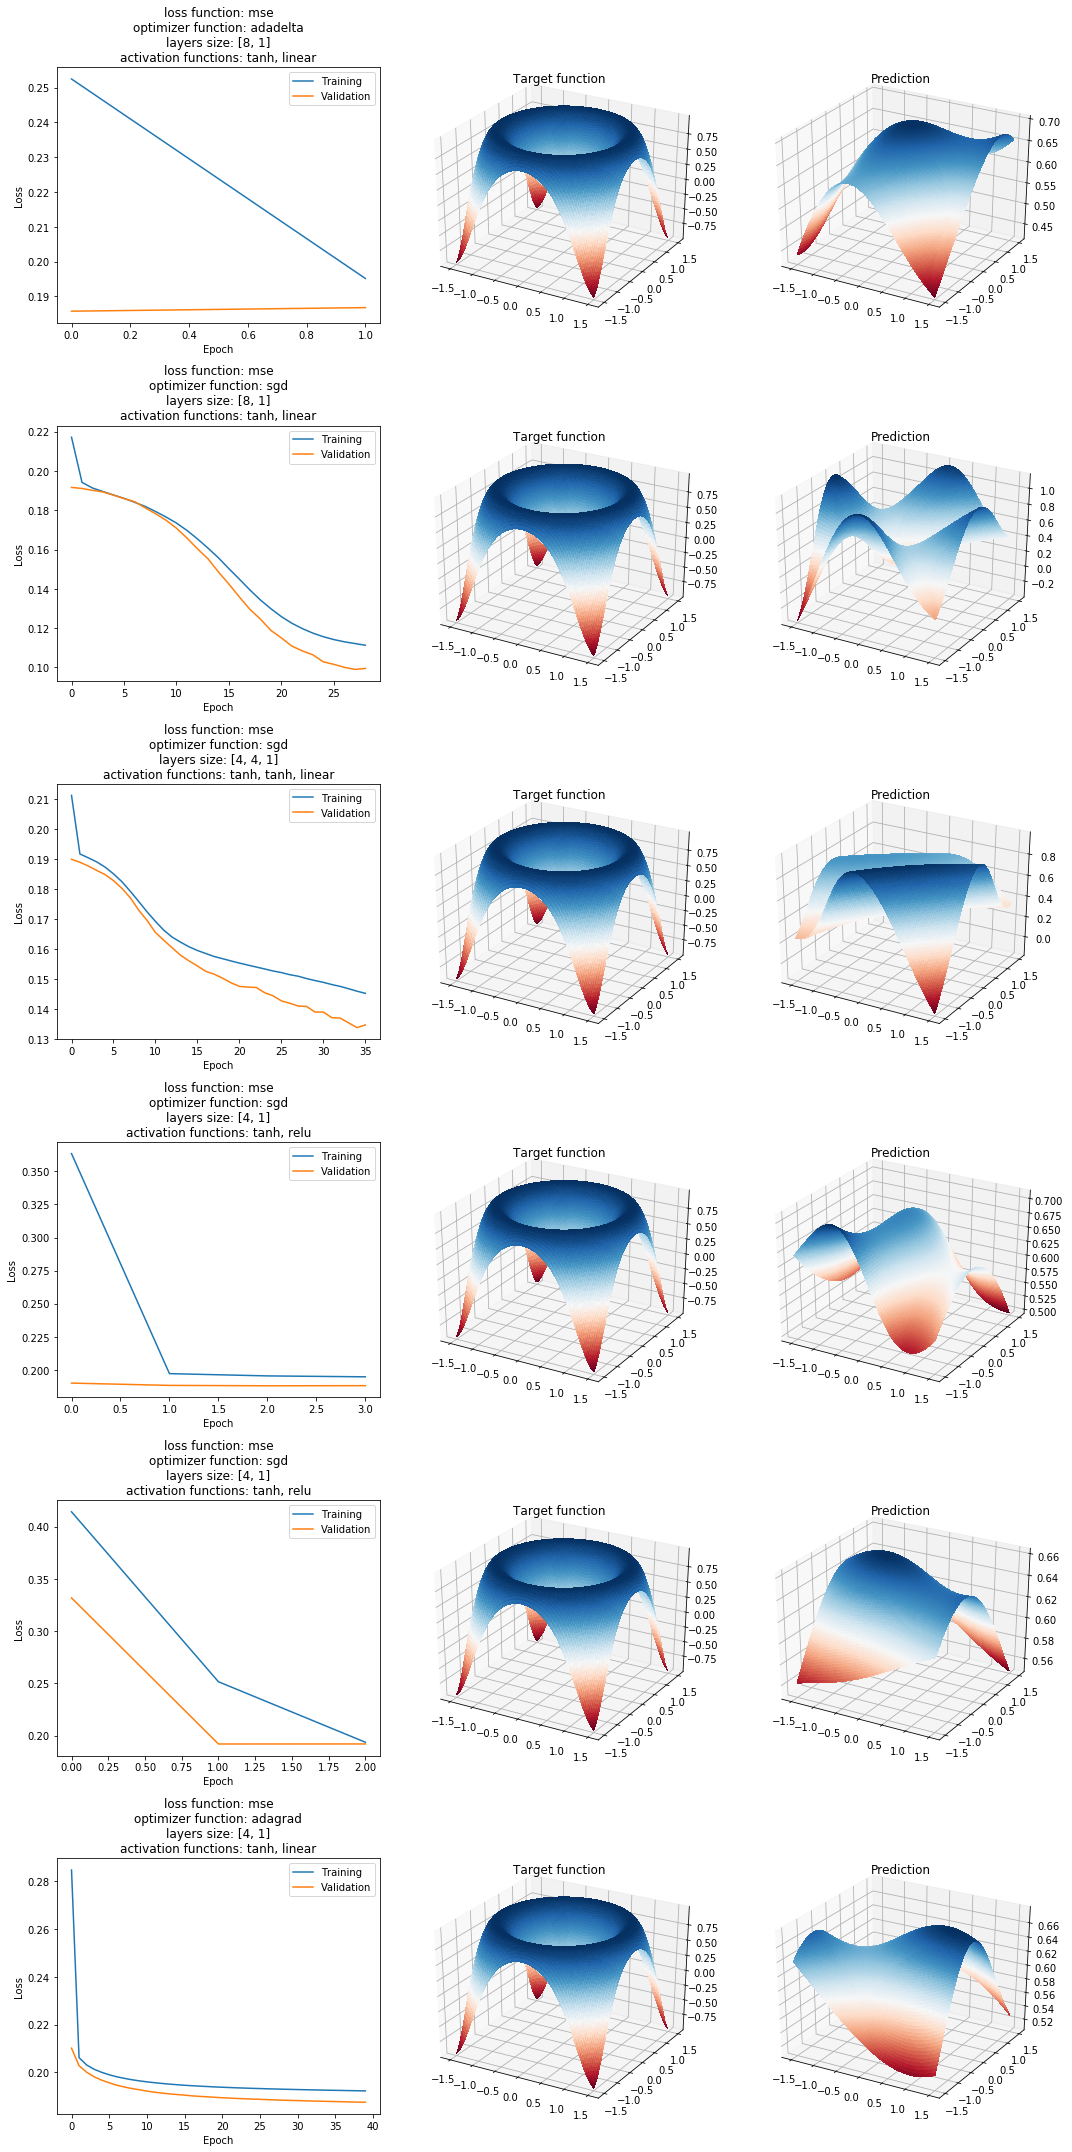

In [7]:
# Plot training info and compare predictions to target data.
fig = plt.figure(figsize = (15, 5 * len(models)))

def target_fn_alt(x, y):
    # Enable target_fn to work with meshgrids.
    return target_fn([x, y])

for i, (model, history) in enumerate(zip(models, model_histories)):
    # Validation results
    ax = fig.add_subplot(len(models), 3, 3 * i + 1)
    ax.plot(history.history["loss"])
    ax.plot(history.history["val_loss"])
    ax.set_title(
        "loss function: " + model.loss_fn
        + "\noptimizer function: " + model.optimizer_fn
        + "\nlayers size: " + str(model.layers_size)
        + "\nactivation functions: " + ", ".join(model.activation_functions)
    )
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epoch")
    ax.legend(["Training", "Validation"], loc = "best")
    
    ax = fig.add_subplot(len(models), 3, 3 * i + 2, projection = "3d")
    ax.set_title("Target function")
    out_predicted = model.network.predict(in_target)
    x = [pt[0] for pt in in_target]
    y = [pt[1] for pt in in_target]
    X, Y = np.meshgrid(
        np.linspace(x_min, x_max, 100),
        np.linspace(y_min, y_max, 100)
    )
    surf = ax.plot_surface(
        X, Y,
        target_fn_alt(X, Y),
        rstride = 1,
        cstride = 1, 
        cmap = plt.cm.RdBu,
        linewidth = 0,
        antialiased = False
    )

    ax = fig.add_subplot(len(models), 3, 3 * i + 3, projection = "3d")
    ax.set_title("Prediction")
    data = []
    for x, y in zip(X.flatten(), Y.flatten()):
        data.append([x, y])
    z = model.network.predict(np.array(data))
    z = z.reshape((100, 100))
    surf = ax.plot_surface(
        X, Y,
        z,
        rstride = 1,
        cstride = 1,
        cmap = plt.cm.RdBu,
        linewidth = 0,
        antialiased = False
    )

fig.tight_layout()
plt.show()

###### Comments
Since a scatter plot would be hard to read, especially when superimposed to the surface plot of the target function (that is the middle plot in the rows above), I chose instead to make the networks produce another surface plot (shown on the right).

I enabled the *early stopping* feature so that the training stops when the accuracy on the validation data stops improving: this may be a good way to prevent overfitting, at the same time reducing the training time.

I tried experimenting with different layer structures, activation and loss functions to see which combination would give the best results.
The cell above lists some of the best results I managed to achieve.
Some remarks I wrote in the previous exercise continue to hold here: layers of great size do not help, just one middle layer is enough, a combination of *tanh* and *linear* activation functions is probably the best.

Overall it seems that the networks succeeded, more or less, to describe the model correctly near the edges of the domain.
In the middle, however, it is much worse: not all models recognised that there was a "basin" at the origin.
None of them, moreover, managed to recognise the circular symmetry of the function, or its maximal points.

In the end I would say that the second from the top, judging from the accuracy levels it reached and the plots on the right, was the best among those I trained.